# **COVID-19 Imapct on Digital Learning**

![](https://mk0tiptopbrainjs8r5q.kinstacdn.com/wp-content/uploads/2020/07/pros-and-cons-of-online-learning.jpg)

*The outbreak of the SARS-Cov-2 virus pandemic causing the COVID-19 disease, which spread rapidly around the world, has forced billions of people to limit direct contact with each other. Many companies have switched to remote work, and commerce has largely moved to the Internet. Schools, universities and other educational institutions did the same - they switched to remote learning where teachers conduct lessons via the Internet for their students. It was certainly a challenge for teachers and students, but many ready-made tools that helped in conducting classes and lectures came to the rescue. Rapidly developing before the pandemic and gaining in popularity, e-learning has thus become the best form of education in these strange times. Today we'll look at this problem from the perspective of the specific tools used in the USA in 2020, thus checking: when, where, how and why specific learning products were used.* 

## **Importing all the necessary packages**

In [ ]:
# linear algebra
import numpy as np 
import math

# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd 

#file path
import glob
import os

#data visualization and graphical plotting
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#visualisations to understand the presence and distribution of missing data 
import missingno as msno 

#Build better models more efficiently with Weights & Biases experiment tracking
import wandb

#Geospatial analysis
import folium
from geopy.geocoders import Nominatim
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

![](https://www.pngitem.com/pimgs/m/379-3795922_wandb-logo-circle-hd-png-download.png)


### **Integrating W&B for visualizations and logging artifacts!**

[LearnPlatform COVID-19 Impact on Digital Learning W&B Dashboard](https://wandb.ai/eyerusalem/LearnPlatform?workspace=user-eyerusalem)

- To get the API key, an account is to be created on the [website first](https://wandb.ai/site).
- Next, use secrets to use API Keys more securely.

In [ ]:
!pip install -qqq wandb 

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()


CONFIG = {'competition': 'learnplatform', '_wandb_kernel': 'eyerus'}

os.environ["WANDB_SILENT"] = "true"

In [ ]:
wandb.login()

## **Reading the data files**

## Engagement data

The engagement data are based on LearnPlatform’s Student Chrome Extension. The extension collects page load events of over 10K education technology products in our product library, including websites, apps, web apps, software programs, extensions, ebooks, hardwares, and services used in educational institutions. 

The engagement data are aggregated at school district level, and each file in the folder engagement_data represents data from one school district. The 4-digit file name represents district_id which can be used to link to district information in district_info.csv. The lp_id can be used to link to product information in product_info.csv.

|**Name**               |          **Description**                                        |
|-------------------    |:--------------------------------:                               |
|  time                 |                             date in "YYYY-MM-DD"                |
|  lp_id                |The unique identifier of the product                             |
|  pct_access           |Percentage of students in the district <br>have at least one page-load event of a <br> given product and on a given day |
| engagement_index       |Total page-load events per one thousand students <br> of a given product and on a given day                              |

In [ ]:
path = '../input/learnplatform-covid19-impact-on-digital-learning/engagement_data' 
all_files = glob.glob(path + "/*.csv")
Updated_Df = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    district_id = filename.split("/")[4].split(".")[0]
#     print (district_id)
    df["district_id"] = district_id
    Updated_Df.append(df)
engagement_df = pd.concat( Updated_Df)
engagement_df = engagement_df.reset_index(drop=True)
engagement_df.head()    
    


## Product information data
The product file products_info.csv includes information about the characteristics of the top 372 products with most users in 2020. The categories listed in this file are part of LearnPlatform's product taxonomy.

- LP ID - the unique identifier of the product. URL
- Product Name
- Provider/Company Name
- Sector(s) - sector of education where the product is used.
- Primary Essential Function - the basic function of the product. There are two layers of labels here. Products are first labeled as one of these three categories: LC = Learning & Curriculum, CM = Classroom Management, and SDO = School & District Operations. Each of these categories have multiple sub-categories with which the products were labeled.

In [ ]:
products_df = pd.read_csv("../input/learnplatform-covid19-impact-on-digital-learning/products_info.csv")
products_df.head()

## District information data

The district file districts_info.csv includes information about the characteristics of school districts, including data from, NCES (2018-19),FCC (Dec 2018), and Edunomics Lab.

- distrist_id
- state
- locale
- pct_black/hispanic - percentage of students in the districts identified as Black or Hispanic based on 2018-19 NCES data.
- pct_free/reduced - percentage of students in the districts eligible for free or reduced-price lunch based on 2018-19 NCES data.
- county_connections_ratio - ratio (residential fixed high-speed connections over 200 kbps in at least one direction/households) based on the county level data from FCC From 477 (December 2018 version).
- pp_total_raw - per-pupil total expenditure (sum of local and federal expenditure) from Edunomics Lab's National Education Resource Database on Schools (NERD$) project.



In [ ]:
districts_df = pd.read_csv("../input/learnplatform-covid19-impact-on-digital-learning/districts_info.csv")
districts_df.head()

## **Missing values**

In [ ]:
# missing values for product data
msno.bar(products_df,color='lightblue', sort="ascending", figsize=(10,5), fontsize=12)
plt.show()

In [ ]:
# missing values for district data
msno.bar(districts_df,color='cadetblue', sort="ascending", figsize=(10,5), fontsize=12)
plt.show()

In [ ]:
# missing values for engagement data
msno.bar(engagement_df,color='skyblue', sort="ascending", figsize=(10,5), fontsize=12)
plt.show()

# **EDA 📊**

In [ ]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

#====== Function to plot WandB bar chart ======
def plot_wb_bar(df,col1,col2): 
    run = wandb.init(project='LearnPlatform', job_type='image-visualization',name=col1,config = CONFIG, anonymous="allow")
    
    dt = [[label, val] for (label, val) in zip(df[col1], df[col2])]
    table = wandb.Table(data=dt, columns = [col1,col2])
    wandb.log({col1 : wandb.plot.bar(table, col1,col2,title=col1)})
    run.finish()
    
#====== Function to create a dataframe of value counts ======
def count_values(df,col,top=False):
    df = pd.DataFrame(df[col].value_counts().reset_index().values,columns=[col, "counts"])
    if top==True: df=df[:10]
    return df

#====== Function to create a dataframe ======
def intermediate_df(col, labels, sizes):
    d = pd.DataFrame()
    d[col] = labels
    d['counts'] = sizes
    return d

pal1 = ["#fec5bb","#fcd5ce","#fae1dd","#f8edeb","#e8e8e4","#d8e2dc","#ece4db","#ffe5d9","#ffd7ba","#fec89a"]
pal2 = ["#ffcbf2","#f3c4fb","#ecbcfd","#e5b3fe","#e2afff","#deaaff","#d8bbff","#d0d1ff","#c8e7ff","#c0fdff"]
pal3 = ["#d6d2d2","#f1e4f3","#f4bbd3","#f686bd","#fe5d9f"]
pal4 = ["#a09abc","#b6a6ca","#d5cfe1","#e1dee9","#d4bebe"]

In [ ]:
plot_wb_bar(count_values(districts_df,"state"),"state", 'counts')

## District Data visualization

In [ ]:
# Distribution of state
plt.figure(figsize=(16, 10))
sns.countplot(y="state",data=districts_df,order=districts_df.state.value_counts().index,palette="Blues",linewidth=3)
plt.title("State Distribution",font="Serif", size=20)
plt.show()

In [ ]:
#districts state wordcloud
from wordcloud import WordCloud
cloud = WordCloud(width=1440, height=1080).generate(" ".join(districts_df['state'].astype(str)))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)
plt.axis('off')

In [ ]:
# Locale distribution

fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Locale Distribution', size = 20, font="Serif")
explode = (0.01, 0.01, 0.01, 0.01)
labels = list(districts_df.locale.value_counts().index)
sizes = districts_df.locale.value_counts().values
ax.pie(sizes, explode=explode,startangle=60, labels=labels,autopct='%1.0f%%',
       pctdistance=0.7, colors=['slategray','lavender','thistle','rosybrown'] )
plt.show()

In [ ]:
plot_wb_bar(count_values(districts_df,"locale"),"locale", 'counts')

In [ ]:
## pct_free/reduced
sns.countplot(data= districts_df, x = "pct_free/reduced", color='skyblue')
plt.show()

## 

## Product Data Visualization

In [ ]:
#Distribution of Sector(s) 
products_sec=products_df['Sector(s)'].value_counts().reset_index()

products_sec.columns = ['Sector(s)','percent']

products_sec['percent'] /= len(products_df)
fig = px.pie(
    products_sec, 
    names='Sector(s)', 
    values='percent',
    color_discrete_sequence=px.colors.sequential.Mint,
    title='Distribution of Sector(s) in the Product Information Data:', 
    width=700,
    height=500
)
fig.show()


In [ ]:
plot_wb_bar(count_values(products_df,"Provider/Company Name",top=True),"Provider/Company Name", 'counts')


In [ ]:
# Distribution of Education Sectors
c1=c2=c3=0
for s in products_df["Sector(s)"]:
    if(not pd.isnull(s)):
        s = s.split(";")
        for i in range(len(s)):
            sub = s[i].strip()
            if(sub == 'PreK-12'): c1+=1
            if(sub == 'Higher Ed'): c2+=1
            if(sub == 'Corporate'): c3+=1

fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Sector Distribution', size = 20, font="Serif")
explode = (0.02, 0.02, 0.02)
labels = ['PreK-12','Higher Ed','Corporate']
sizes = [c1,c2, c3]
ax.pie(sizes, explode=explode,startangle=60, labels=labels,autopct='%1.2f%%', pctdistance=0.7, colors=['lavender','thistle','rosybrown'])
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()

In [ ]:
plot_wb_bar(intermediate_df('Sector', labels, sizes),"Sector", 'counts')


In [ ]:
plot_wb_bar(intermediate_df('Primary Essential Function', labels, sizes),"Primary Essential Function", 'counts')

In [ ]:
#Distribution of top 15 Provider/Company Name
plt.figure(figsize=(16,10))
sns.countplot(y='Provider/Company Name', data= products_df, order= products_df['Provider/Company Name'].value_counts().index[:15])
plt.title('Top 15 Provider/Company Name')
plt.show()


As we can see in the above chart the first 3 places are occupied by well known companies -Google,Microsoft and  houghton mifflin harcourt having values above five. which means those are the one that mainly offer online learning website.

In [ ]:
# identifying unique learning methods
print(products_df['Primary Essential Function'].unique())

In [ ]:
#Distribution of Primary Essential Function
primary_essential_main = []
primary_essential_sub = []
for s in products_df["Primary Essential Function"]:
    if(not pd.isnull(s)):
        s1 = s.split("-",1)[0].strip()
        primary_essential_main.append(s1)
    else:
        primary_essential_main.append(np.nan)
    
    if(not pd.isnull(s)):
        s2 = s.split("-",1)[1].strip()
        primary_essential_sub.append(s2)
    else:
        primary_essential_sub.append(np.nan)

products_df["primary_essential_main"] = primary_essential_main
products_df["primary_essential_sub"] = primary_essential_sub


In [ ]:
# Visualizing the Primary Essential Function Learn Platform catagories
LP1=LP2=LP3=0

for s in products_df["primary_essential_main"]:
    if(not pd.isnull(s)):
        LP1 += s.count("CM")
        LP2 += s.count("LC")
        LP3 += s.count("SDO")

fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Primary Essential Function', size = 30, font="Serif")
explode = (0.02, 0.02, 0.02)
labels = ['CM','LC','SDO']
sizes = [LP1, LP2, LP3]
ax.pie(sizes, explode=explode,startangle=60, labels=labels,autopct='%1.2f%%', pctdistance=0.7, colors=["lightpink",'lavender','thistle'])
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()

In [ ]:
plot_wb_bar(count_values(products_df,"primary_essential_sub"),"primary_essential_sub", 'counts')

In [ ]:
# Visualizing the Primary Essential Function Learn Platform sub-catagories
plt.figure(figsize=(16, 20))
sns.countplot(y='primary_essential_sub', data=products_df, order=products_df["primary_essential_sub"].value_counts().index, color= 'thistle')
plt.title("Primary Essential Function(Sub)",font="Serif")
plt.show()


## **Merging files 📁**

## *Merging Engagement Data and Product Data*

In [ ]:
engagement_df['time'] = pd.to_datetime(engagement_df['time'])

In [ ]:
print(products_df["LP ID"].nunique())
print(engagement_df["lp_id"].nunique())

In [ ]:
product_engage = pd.merge(products_df, engagement_df, left_on='LP ID', right_on='lp_id')
product_engage.head()

### *Visualizaing the Merged Data(Product_Engagement)*

In [ ]:
# Top 15 Products With atleast one-page load event and With number of page-load per 1000 students

one_page= product_engage.groupby("Product Name")["pct_access"].mean().sort_values(ascending=False).head(15)
one_page=one_page.reset_index()

Page_load= product_engage.groupby("Product Name")["engagement_index"].sum().sort_values(ascending=False).head(15)
Page_load=Page_load.reset_index()


# plot
plt.figure(figsize=(15,4))

plt.subplot(121)
sns.barplot(data= one_page ,x="Product Name", y="pct_access", palette="ch:s=.25,rot=-.25")
plt.xlabel('Product Name')
plt.xticks(rotation=90)
plt.ylabel('Mean percentage of students')
plt.title("With at least one-page load event")


plt.subplot(122)
sns.barplot(data= Page_load ,x="Product Name", y="engagement_index", palette="flare")
plt.xlabel('Product Name')
plt.xticks(rotation=90)
plt.ylabel('Page-load per 1000 students')
plt.title("With number of page-load per 1000 students")



*Google Classroom and Google Docs are the two products having maximum accessibility to the students in terms of one-page load event and total-page load event.*

## *Merging Engagement Data and Districts Data*

In [ ]:
print(districts_df["district_id"].nunique())
print(engagement_df["district_id"].nunique())

In [ ]:
engagement_df["district_id"] = engagement_df["district_id"].astype(str).astype(int)
districts_engagement_data = pd.merge(districts_df, engagement_df, left_on='district_id', right_on='district_id')
districts_engagement_data.head()

### *Visualizing the Merged Data(Districts_Engagement)*

In [ ]:
# Plot data in a time-series

def plot_time_series(df,col1,col2,col3):
    max_list = df[[col1,col2]]\
        .groupby([col1])[col2].mean()\
        .sort_values(ascending=False).index[:5].tolist()

    df = df[df[col1].isin(max_list)].reset_index(drop=True)[[col3, col1, col2]]
    df = df.pivot_table(index=col3, columns=col1, values=col2)

    fig = px.line(df, facet_col=col1, facet_col_wrap=1, width=800, height=800)
    fig.update_layout(
                      title=(col1 + " , " + col2 + " , " + col3).title(),
                      title_x=0.39,
                      template="plotly_white",
                      paper_bgcolor='#f5f7f8',
                      font = {'family': 'Serif', 'size': 20}
                     )
    fig.show()

In [ ]:
plot_time_series(districts_engagement_data,"state","pct_access","time")
plot_time_series(districts_engagement_data,"state","engagement_index","time")
plot_time_series(districts_engagement_data,"locale","pct_access","time")
plot_time_series(districts_engagement_data,"locale","engagement_index","time")


# **Geospatial Analysis 🗺️**

In [ ]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="http")

def feature_generation(df):
    lat=[]
    long=[]
    for i in df['state']: 
        location = geolocator.geocode(i)
        try:
            lat.append(location.latitude)
            long.append(location.longitude)
        except:
            lat.append("NA")
            long.append("NA")
    df['Latitude'] = lat
    df['Longitude'] = long
    
    return df

def map_df(df,col1,col2):
    df = pd.DataFrame(df[[col1,col2]]\
            .groupby([col1])[col2].mean()\
            .sort_values(ascending=False)[:20]).reset_index()
    
    df = feature_generation(df)
    
    return df

state_access = map_df(districts_engagement_data, "state", "pct_access")
state_engagement_index = map_df(districts_engagement_data, "state", "engagement_index")


## **Base Map 🌎**

In [ ]:
north_america_map = folium.Map(location=[38.9, -77.05], tiles='Stamen Watercolor', zoom_start=3)
north_america_map

## State and Percentage Access (Top 20) 🌎

In [ ]:
mc = MarkerCluster()
for idx, row in state_access.iterrows():
    if not math.isnan(row['Longitude']) and not math.isnan(row['Latitude']):
        popup = """
        State : <b>%s</b><br>
        Percentage Access : <b>%s</b><br>
        """ % (row['state'], row['pct_access'])
        mc.add_child(Marker([row['Latitude'], row['Longitude']],tooltip=popup))
    north_america_map.add_child(mc)
north_america_map

## This is what my[ project ](https://wandb.ai/eyerusalem/LearnPlatform?workspace=user-eyerusalem)looks like on the W&B dashboard ⬇️
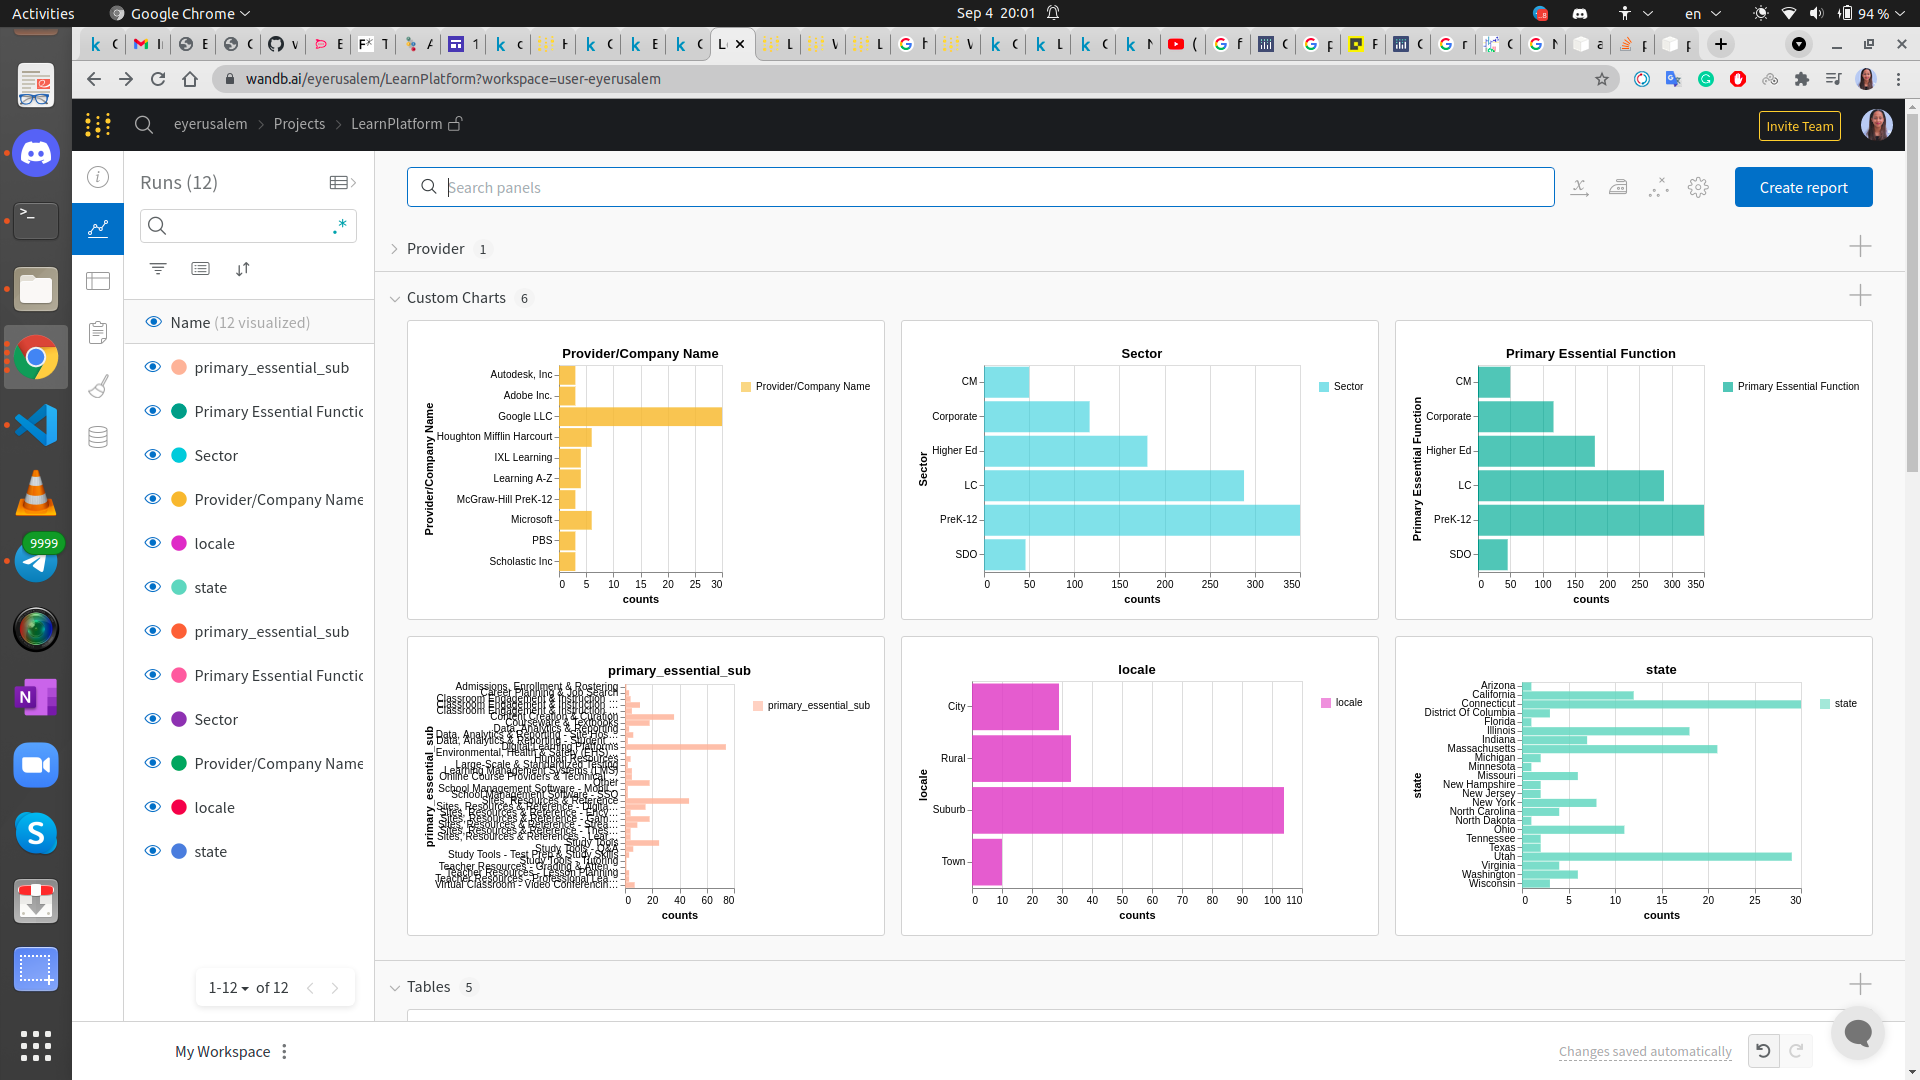)